# CatBoost Regression
This notebook demonstrates the use of CatBoost for regression tasks.

## Import Libraries
Import necessary libraries for data manipulation, visualization, and modeling.

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Load Dataset
Load the dataset and inspect its structure.

In [23]:
df = pd.read_csv('datasets/luxury_watches_featured.csv')
df.columns

Index(['Brand', 'Model', 'Case Material', 'Strap Material', 'Crystal Material',
       'Dial Color', 'Case Diameter', 'Case Thickness', 'Band Width',
       'Case_Size_Category', 'Case_Proportion', 'Movement Type',
       'Movement_Complexity', 'Power Reserve', 'Complications',
       'Has_Complication', 'Water Resistance', 'Water_Tier', 'Dial_Score',
       'Complication_Score', 'Material_Match', 'Luxury_Index', 'Brand_Tier',
       'Model_Tier', 'Brand_Tier_label_encoded', 'Model_Tier_label_encoded',
       'Brand_Tier_target_encoded', 'Model_Tier_target_encoded', 'Brand_Case',
       'Brand_Crystal', 'Material_Crystal_Movement', 'Price'],
      dtype='object')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Brand                      507 non-null    object 
 1   Model                      507 non-null    object 
 2   Case Material              507 non-null    object 
 3   Strap Material             507 non-null    object 
 4   Crystal Material           507 non-null    object 
 5   Dial Color                 507 non-null    object 
 6   Case Diameter              507 non-null    float64
 7   Case Thickness             507 non-null    float64
 8   Band Width                 507 non-null    float64
 9   Case_Size_Category         507 non-null    int64  
 10  Case_Proportion            507 non-null    float64
 11  Movement Type              507 non-null    object 
 12  Movement_Complexity        507 non-null    int64  
 13  Power Reserve              507 non-null    float64

In [25]:
import catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.inspection import permutation_importance

In [26]:
X = df.drop(columns=['Complications', 'Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_columns = [
    'Brand', 'Model', 'Case Material', 'Strap Material', 'Movement Type',
    'Dial Color', 'Crystal Material'
]

categorical_columns = X.select_dtypes(include='object').columns.tolist()

model = CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1, loss_function='RMSE', cat_features=categorical_columns, verbose=False)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
importances = pd.DataFrame({'feature': X_test.columns, 'importance': perm.importances_mean})
importances = importances.sort_values('importance', ascending=False)

print(importances)

print(f'R2 Score: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

                      feature  importance
2               Case Material    0.158437
0                       Brand    0.135613
21                 Brand_Tier    0.019597
20               Luxury_Index    0.017813
23   Brand_Tier_label_encoded    0.009175
7              Case Thickness    0.006091
13              Power Reserve    0.005176
22                 Model_Tier    0.004514
25  Brand_Tier_target_encoded    0.004302
8                  Band Width    0.004086
10            Case_Proportion    0.004068
15           Water Resistance    0.003671
6               Case Diameter    0.002364
18         Complication_Score    0.000858
12        Movement_Complexity    0.000033
19             Material_Match    0.000000
4            Crystal Material   -0.000059
14           Has_Complication   -0.000086
28              Brand_Crystal   -0.000617
9          Case_Size_Category   -0.000627
11              Movement Type   -0.000803
24   Model_Tier_label_encoded   -0.001493
29  Material_Crystal_Movement   -0

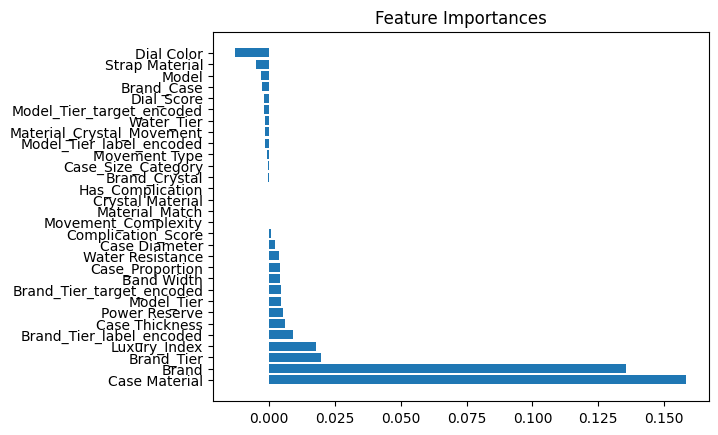

In [27]:
plt.barh(importances['feature'], importances['importance'])
plt.title("Feature Importances")
plt.show()

## Fine-Tune CatBoost Model
Perform hyperparameter tuning to find the best parameters for the CatBoost model.

In [28]:
scorer = make_scorer(r2_score)

cb_model =CatBoostRegressor(random_state=42, loss_function='RMSE', cat_features=categorical_columns)

param_grid = {
    'iterations': [200, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'bagging_temperature': [0.1, 0.3, 0.5]
}

grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid,
                           scoring=scorer, cv=3, n_jobs=-1, verbose=False)

grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best R2 Score: {grid_search.best_score_:.4f}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'R2 Score: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

0:	learn: 8305.0606119	total: 17.7ms	remaining: 8.82s
1:	learn: 8026.6866047	total: 36.3ms	remaining: 9.03s
2:	learn: 7805.3984103	total: 48.7ms	remaining: 8.07s
3:	learn: 7558.2982119	total: 66.8ms	remaining: 8.29s
4:	learn: 7282.2600605	total: 85ms	remaining: 8.41s
5:	learn: 7047.6997451	total: 105ms	remaining: 8.64s
6:	learn: 6823.3894540	total: 125ms	remaining: 8.79s
7:	learn: 6631.4130674	total: 140ms	remaining: 8.61s
8:	learn: 6441.0569870	total: 160ms	remaining: 8.74s
9:	learn: 6251.4016011	total: 178ms	remaining: 8.73s
10:	learn: 6066.8188720	total: 196ms	remaining: 8.7s
11:	learn: 5903.7014423	total: 215ms	remaining: 8.76s
12:	learn: 5755.3349867	total: 234ms	remaining: 8.78s
13:	learn: 5599.9150307	total: 253ms	remaining: 8.79s
14:	learn: 5443.8927826	total: 294ms	remaining: 9.51s
15:	learn: 5347.3236193	total: 310ms	remaining: 9.39s
16:	learn: 5217.3901567	total: 357ms	remaining: 10.1s
17:	learn: 5081.1417748	total: 378ms	remaining: 10.1s
18:	learn: 4955.1286542	total: 396ms

## Evaluate CatBoost Model
Evaluate the model's performance using the best parameters obtained from fine-tuning.

In [29]:
best_cb_model = CatBoostRegressor(iterations=500, depth=4, learning_rate=0.05, loss_function='RMSE', cat_features=categorical_columns, bagging_temperature=0.1, verbose=False)

best_cb_model.fit(X_train, y_train)

y_pred = best_cb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'R2 Score: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

R2 Score: 0.8929
RMSE: 2324.4167
MAE: 1742.4933


In [30]:
import joblib

joblib.dump(best_cb_model, 'models/catboost_model.pkl')

['models/catboost_model.pkl']